In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import objectives
from keras.datasets import mnist

Using TensorFlow backend.
/usr/lib/python3/dist-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.24.1) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
# Hyperparameters
batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
nb_epoch = 10
epsilon_std = 1.0

#encoder
'''
The encoder's jo is to map inputs to our hidden distribution
parameters. We take the input and send it through a dense fully
connected layer with ReLU (classic non-linearity to squash
dimensionality). Next, we convert the input data into two
parameters in the hidden space. We predefine the size using
dense, fully connected layers — z mean and z log sigma.
'''
x = Input(batch_shape = (batch_size, original_dim))
h = Dense(intermediate_dim, activation = 'relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

print(z_mean)
print(z_log_var)


Tensor("dense_2/BiasAdd:0", shape=(100, 2), dtype=float32)
Tensor("dense_3/BiasAdd:0", shape=(100, 2), dtype=float32)


In [3]:
'''
The decoder(in the next block) will take z as its input
and output the parameters to the probability distribution 
of the data.
Epsilon is a random normal tensor
'''

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.)
    return z_mean + K.exp(z_log_var / 2) * epsilon
    
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

#latent hidden state
print(z)

Tensor("lambda_1/add:0", shape=(100, 2), dtype=float32)


In [4]:
'''
we first initialize it with two fully connected layers and
their own respective activation functions. Because the data
is extracted from a small dimensionality to a larger one, some
of it will be lost in the reconstruction process.
'''

#decoder
# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

print(x_decoded_mean)

Tensor("dense_5/Sigmoid:0", shape=(100, 784), dtype=float32)


In [5]:
'''
The first term below measures the reconstruction loss. If the
decoder output is bad at reconstructing data, the cost in terms
of loss will be considerable at this point. The next term is a
regularizer, meaning it keeps the representation of each digit as
diverse as possible. So for instance, if two different people were 
to write out the digit three, the representations might end up
looking very different because, of course, different people write
differently. This can be bad, and the regularizer comes to rescue!
We penalize bad behaviour (like the example here) and ensure similar
representations are close together. Our total loss function is
defined as the sum of our reconstruction term, and the KL divergence
regularization term.
'''

#loss
def vae_loss(x, x_decoded_mean):
    xent_loss = original_dim * objectives.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

vae = Model(x, x_decoded_mean)
vae.compile(optimizer='rmsprop', loss=vae_loss)

In [6]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
        shuffle=True,
        nb_epoch=nb_epoch,
        batch_size=batch_size,
        validation_data=(x_test, x_test),verbose=1)

11493376/11490434 [==============================] - 8s 1us/step


/home/sol/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  del sys.path[0]


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 6s 94us/step - loss: 189.8138 - val_loss: 171.9934
Epoch 2/10
60000/60000 [==============================] - 5s 84us/step - loss: 169.5364 - val_loss: 168.2614
Epoch 3/10
60000/60000 [==============================] - 5s 89us/step - loss: 166.7396 - val_loss: 165.5625
Epoch 4/10
60000/60000 [==============================] - 5s 91us/step - loss: 164.6561 - val_loss: 163.7071
Epoch 5/10
60000/60000 [==============================] - 5s 90us/step - loss: 163.1290 - val_loss: 162.6128
Epoch 6/10
60000/60000 [==============================] - 5s 84us/step - loss: 161.9428 - val_loss: 161.7886
Epoch 7/10
60000/60000 [==============================] - 5s 84us/step - loss: 160.9571 - val_loss: 161.0021
Epoch 8/10
60000/60000 [==============================] - 5s 88us/step - loss: 160.0089 - val_loss: 160.1528
Epoch 9/10
60000/60000 [==============================] - 5s 87us/step - loss:

x:  Tensor("input_1:0", shape=(100, 784), dtype=float32)


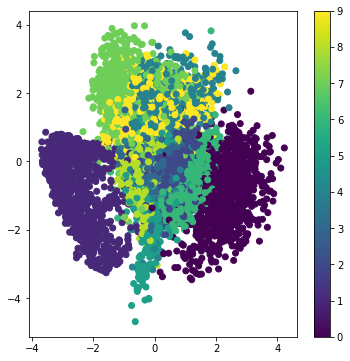

In [15]:
#plot latent/hidden space

# build a model to project inputs on the latent space
encoder = Model(x, z_mean)
print("x: ", x)

# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

[[-1.64485363 -1.64485363]]
[[1.43423243e-23 1.81127686e-23 1.73789891e-23 1.24605416e-23
  6.91847738e-24 1.30007291e-23 1.23664029e-23 8.17771711e-24
  9.80665413e-24 1.69058998e-23 7.26556355e-24 1.39019048e-23
  1.90578483e-22 2.38469723e-22 2.22812958e-23 1.69738807e-23
  2.71529615e-23 1.22965469e-23 1.66208307e-23 1.97163509e-23
  2.25031282e-23 1.59167408e-23 9.05328803e-24 8.73104071e-24
  1.47801105e-23 1.46607827e-23 2.69006807e-23 6.61080545e-24]
 [1.74473423e-23 2.85136519e-23 1.37867232e-23 9.94445788e-24
  2.82385856e-24 2.24846559e-25 7.05669097e-29 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  2.00757583e-34 9.11234267e-36 1.51912359e-36 3.36130185e-33
  1.04924116e-26 5.83655133e-17 8.55717624e-23 8.87990981e-24
  1.22107732e-23 1.73047652e-23 1.02441327e-23 4.64238332e-24]
 [1.14328215e-23 9.35493424e-24 5.73579384e-24 9.50319039e-25
  4.52438905e-24 3.83514606e-23 0.000000

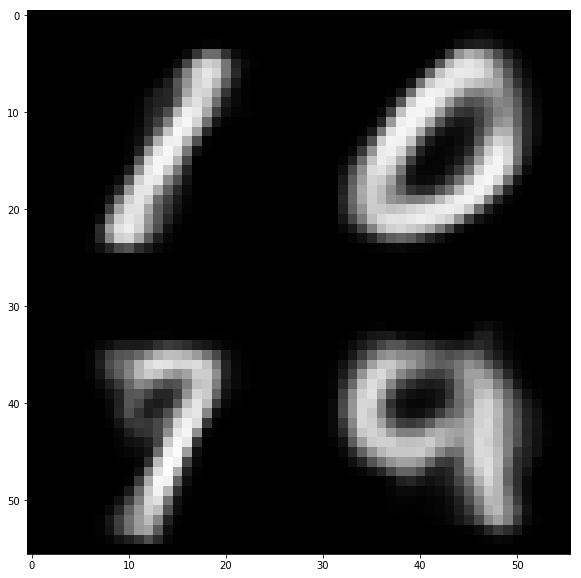

In [13]:
'''
Another way to represent this is to generate digits by scanning
the latent plan, sampling latent points at regular intervals and
generating the corresponding digit for each of these points like so:
'''

# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

# display a 2D manifold of the digits
n = 2  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])        
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)        
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()